In [31]:
import torch
import torch.nn as nn
import numpy as np
import time
from function import fun1,fun2,fun3
from my_NN import Mynetwork
import os
import matplotlib.pyplot as plt

using_func=fun2

def fun1_real(fn, x, dx):
    return fn**2/(1-dx*fn)
def fun2_real(fn, x, dx):
    return 2*x+dx
def fun3_real(fn, x, dx):
    return fn*(np.exp(dx)-1)/dx

now_real_fun=fun2_real

# 确保 model 文件夹存在
os.makedirs('./model_parameter', exist_ok=True)

In [32]:
if torch.cuda.is_available():
    device='cuda'
    print('now using cuda !')
else:
    device='cpu'
    print('now using cpu !')
dtype=torch.float32
    
model=Mynetwork().to(device=device,dtype=dtype)
#load model parameter
new_file_name='./model_parameter/batch256_epoch10000.pth'
model.load_state_dict(torch.load(new_file_name))

now using cuda !


/tmp/ipykernel_2259184/701378339.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(new_file_name))


<All keys matched successfully>

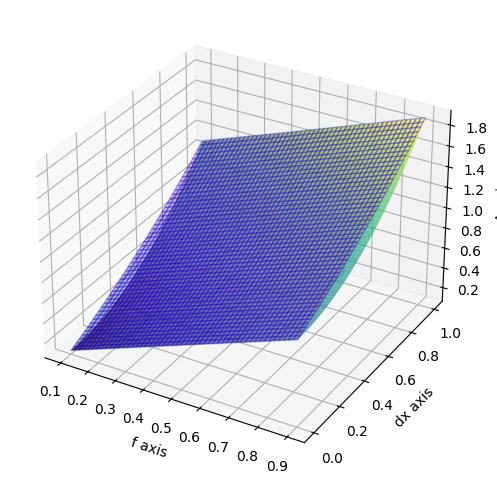

In [33]:
fns = torch.linspace(0.1, 0.9, 1000).to(device,dtype=dtype)
dx = torch.linspace(0, 1, 1000).to(device,dtype=dtype)
fns, dx = torch.meshgrid(fns, dx)
x = torch.zeros((1000, 1000, 1), device=device,dtype=dtype)

real_value = fns.unsqueeze(-1)+dx.unsqueeze(-1)*now_real_fun(fns.unsqueeze(-1), x, dx.unsqueeze(-1))
model_value = fns.unsqueeze(-1)+dx.unsqueeze(-1)*model(fns.unsqueeze(-1), x, dx.unsqueeze(-1))
real_value = real_value.squeeze(-1)
model_value = model_value.squeeze(-1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
# 要将张量传递给不支持 GPU 操作的库（如 Matplotlib）时，需要使用 .cpu() 方法将其转换为 CPU 张量。
ax.plot_surface(fns.cpu().numpy(), dx.cpu().numpy(), real_value.cpu().numpy(), cmap='viridis', alpha=0.7)

# 绘制预测模型的表面
ax.plot_surface(fns.cpu().numpy(), dx.cpu().numpy(), model_value.detach().cpu().numpy(), cmap='inferno', alpha=0.3,color='blue')

ax.set_xlabel('f axis')
ax.set_ylabel('dx axis')
ax.set_zlabel('A axis')
plt.show()

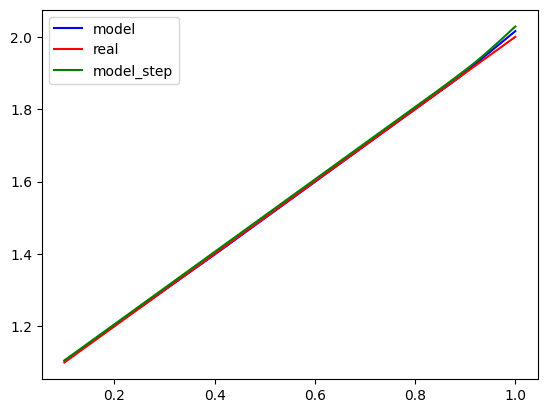

In [34]:
length=100
dx=torch.zeros(length).unsqueeze(-1).to(device=device,dtype=dtype)+1
x=torch.zeros(length).unsqueeze(-1).to(device=device,dtype=dtype)
f0=torch.linspace(0.1,1,length).unsqueeze(-1).to(device=device,dtype=dtype)

model_value_sf=f0.squeeze(-1)+(dx.squeeze(-1))*model(f0,x,dx).squeeze(-1)
real_value_sf=f0.squeeze(-1)+(dx.squeeze(-1))*now_real_fun(f0,x,dx).squeeze(-1)

value=[]
f_step=f0.clone()

step_len=100
x_step=torch.linspace(0,1,step_len+1).unsqueeze(-1).to(device=device,dtype=dtype)
x_step=x_step.repeat(1,length).unsqueeze(-1)
dx_step=torch.zeros(length).unsqueeze(-1).to(device=device,dtype=dtype)+1/step_len

for i in range(step_len):
    f_step=f_step+model(f_step,x_step[i+1],dx_step)*1/step_len
    
plt.plot(f0.detach().cpu(),model_value_sf.detach().cpu(),c='b',label='model')
plt.plot(f0.detach().cpu(),real_value_sf.detach().cpu(),c='r',label='real')
plt.plot(f0.detach().cpu(),f_step.detach().cpu(),c='g',label='model_step')
x_label='f(0)'
y_label='f(1)'
plt.legend()
